# Sección 5 Lección 16: Implementación de un modelo de Clasificación en Python

In [1]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Cargar dataset y convertir a DataFrame
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target

In [2]:
# Eliminar filas con valores missing (por si acaso)
df = df.dropna()

# Mostrar primeras filas
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
# Separar características y variable objetivo
X = df.drop('Target', axis=1) #axis=1 operacion sobre columna
y = df['Target']

In [4]:
# División en entrenamiento (70%) y test (30%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# División del 20% del entrenamiento para validación interna
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=0, stratify=y_train_full)

In [5]:
X_train

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
77,6.7,3.0,5.0,1.7
78,6.0,2.9,4.5,1.5
117,7.7,3.8,6.7,2.2
63,6.1,2.9,4.7,1.4
114,5.8,2.8,5.1,2.4
...,...,...,...,...
97,6.2,2.9,4.3,1.3
96,5.7,2.9,4.2,1.3
62,6.0,2.2,4.0,1.0
60,5.0,2.0,3.5,1.0


In [6]:
y_train

77     1
78     1
117    2
63     1
114    2
      ..
97     1
96     1
62     1
60     1
35     0
Name: Target, Length: 84, dtype: int32

In [7]:
print(y_train.value_counts())

Target
1    28
2    28
0    28
Name: count, dtype: int64


In [8]:
# Entrenar modelo
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [9]:
# Validación
val_preds = classifier.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)*100
print(f"Precisión en validación: {val_acc:.2f}")

Precisión en validación: 76.19


In [10]:
# Test final
test_preds = classifier.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)*100
print(f"Precisión en test: {test_acc:.2f}")

Precisión en test: 97.78


In [11]:
# Precision
prec = precision_score(y_test, test_preds, average='macro')  # o 'binary' si binary class

# Recall
rec = recall_score(y_test, test_preds, average='macro')

# F1 Score
f1 = f1_score(y_test, test_preds, average='macro')

# Matriz de confusión
cm = confusion_matrix(y_test, test_preds)

# Para AUC ROC en multiclase:
# Necesitamos binarizar las etiquetas verdaderas y las probabilidades
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
probs = classifier.predict_proba(X_test)  # matriz [n_samples, n_classes]

# Calculamos AUC ROC macro (promedio simple entre clases)
auc = roc_auc_score(y_test_bin, probs, average='macro', multi_class='ovr')

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, test_preds)

# Imprimir resultados
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-score: {f1:.2f}")
print("Matriz de confusión:")
print(cm)
print(f"AUC ROC: {auc:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")

Precision: 0.98
Recall: 0.98
F1-score: 0.98
Matriz de confusión:
[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]
AUC ROC: 0.98
Cohen's Kappa: 0.97


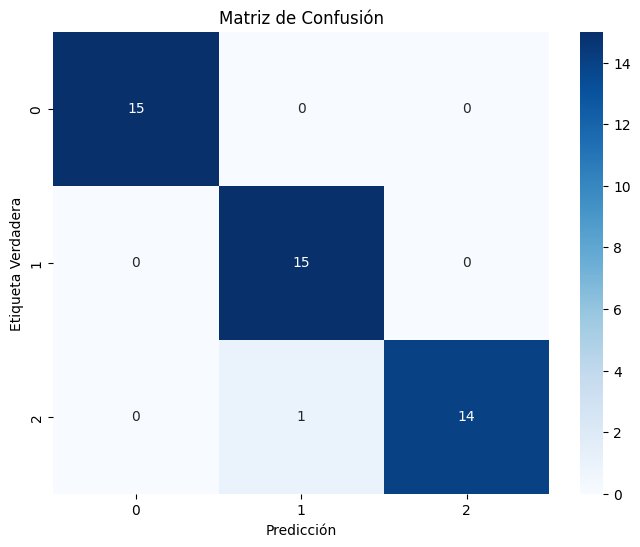

In [12]:
import matplotlib.pyplot as plt         # Biblioteca para gráficos
import seaborn as sns                   # Biblioteca para gráficos estadísticos (matriz de confusión)
from sklearn.metrics import roc_curve, auc  # Funciones para curva ROC y AUC

# --- Matriz de Confusión ---

plt.figure(figsize=(8,6))               # Crear una figura con tamaño 8x6 pulgadas
# Dibujar la matriz de confusión como un mapa de calor
sns.heatmap(cm,                         # matriz de confusión calculada previamente
            annot=True,                 # mostrar los números en cada celda
            fmt='d',                   # formato entero para los números
            cmap='Blues',              # escala de colores azul
            xticklabels=classes,       # etiquetas para columnas (predicciones)
            yticklabels=classes)       # etiquetas para filas (verdaderas)
plt.xlabel('Predicción')                # etiqueta eje x
plt.ylabel('Etiqueta Verdadera')       # etiqueta eje y
plt.title('Matriz de Confusión')       # título del gráfico
plt.show()                             # mostrar gráfico

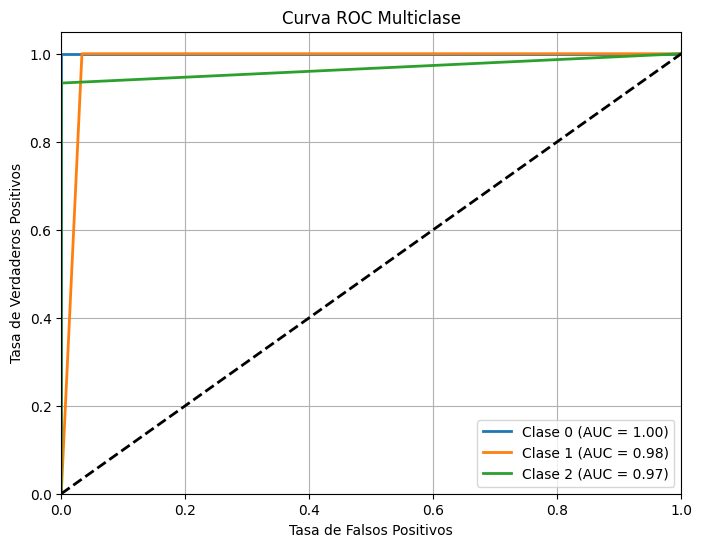

In [13]:
# --- Curva ROC Multiclase ---

plt.figure(figsize=(8,6))               # crear nueva figura para la curva ROC

# Para cada clase calculamos y dibujamos su curva ROC
for i, class_label in enumerate(classes):
    # calcular tasa de falsos positivos (fpr) y verdaderos positivos (tpr)
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
    # calcular el área bajo la curva (AUC) para esta clase
    roc_auc = auc(fpr, tpr)
    # dibujar la curva ROC para esta clase con etiqueta y valor de AUC
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

# dibujar línea diagonal punteada (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])                   # limitar eje x de 0 a 1
plt.ylim([0.0, 1.05])                  # limitar eje y un poco más arriba de 1
plt.xlabel('Tasa de Falsos Positivos') # etiqueta eje x
plt.ylabel('Tasa de Verdaderos Positivos') # etiqueta eje y
plt.title('Curva ROC Multiclase')     # título del gráfico
plt.legend(loc='lower right')          # mostrar leyenda en la esquina inferior derecha
plt.grid(True)                         # mostrar cuadrícula
plt.show()                            # mostrar gráfico